In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit

In [2]:
model_path = "Vp_Marmousi_resampled.txt"

mod = np.loadtxt(model_path)
mod.shape

(851, 176)

In [3]:
### INPUT PARAMETERS ###
model = mod * 1000.0
Qmod = 998 / 1000

### Resampled model
xmax = 17000 # m
zmax = 3500  # m
tmax = 5.0   # s

nx = model.shape[0]
nz = model.shape[1]

dx = xmax / (nx-1)
dz = zmax / (nz-1)

### CFL Rule
vp = model.copy()
vp2 = vp ** 2
vpmax = vp.max()
# dt = dx / (np.sqrt(2.0) * vpmax)
dt = 2 * 1e-3   # ms
nt = int((tmax / dt) + 1)

### Source parameters
f0 = 20   #Hz
src_amp = -1000.0

# Source location
xsrc = 8500.0
zsrc = 40.0

isrc = int(xsrc/dx)
jsrc = int(zsrc/dz)

### Finite-Difference Operator
fd_op = 5
isnap = 50

print("     || Model Parameters ||")
print("=================================")
print("nx, nz      :", nx, nz)
print("nt          :", nt)
print("dx, dz (m)  :", dx, dz)
print("dt     (ms) :", dt * 1e3)
print("=================================")

     || Model Parameters ||
nx, nz      : 851 176
nt          : 2501
dx, dz (m)  : 20.0 20.0
dt     (ms) : 2.0


In [4]:
### Function
@jit(nopython=True)
def ricker(f=f0, length=0.2, dt=0.001):
    t = np.arange(-length/2, (length-dt)/2, dt)
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t**2)) * np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y

@jit (nopython=True)
def gauss_wavelet(x, sigma=1/(2*f0)):
    # x = np.arange(-3, 3.1, 0.1)
    mu = 0.0
    gaussContin = 1/(np.sqrt(2*np.pi) * sigma) * np.exp(-1 * (x-mu)**2/(2 * sigma**2))
    devxgauss= (-x / sigma**2) * gaussContin
    return devxgauss

@jit(nopython=True)
def update_d2p(p, nx, nz, dx, dz, d2px, d2pz, op=fd_op):
    if op == 3:
        for i in range(1, nx-1):
            for j in range(1, nz-1):
                d2px[i, j] = (p[i-1, j] - 2*p[i, j] + p[i+1, j])/(dx**2)
                d2pz[i, j] = (p[i, j-1] - 2*p[i, j] + p[i, j+1])/(dz**2)
    if op == 5:
        for i in range(2, nx-2):
            for j in range(2, nz-2):
                d2px[i, j] = (-p[i-2, j] + 16*p[i-1, j] - 30*p[i, j] + 16*p[i+1, j] - p[i+2, j])/(12 * dx**2)
                d2pz[i, j] = (-p[i, j-2] + 16*p[i, j-1] - 30*p[i, j] + 16*p[i, j+1] - p[i, j+2])/(12 * dz**2)
    return d2px, d2pz

@jit(nopython=True)
def reflection(m):
    m[0, :] = 0
    m[-1, :] = 0
    m[:, 0] = 0
    m[:, -1] = 0
    return m

@jit(nopython=True)
def absorb(p, pnew, vp, nx, nz, dt, dx):
    Nx = nx - 1
    Nz = nz - 1
    
    kappa = vp * dt / dx
    km1 = kappa - 1
    kp1 = kappa + 1
    Kk = km1 / kp1
    
    pnew[0, :] = p[1, :] + Kk[1, :] * (pnew[1, :] - p[0, :])
    pnew[Nx, :] = p[Nx-1, :] + Kk[Nx-1, :] * (pnew[Nx-1, :] - p[Nx, :])
    pnew[:, 0] = p[:, 1] + Kk[:, 1] * (pnew[:, 1] - p[:, 0])
    pnew[:, Nz] = p[:, Nz-1] + Kk[:, Nz-1] * (pnew[:, Nz-1] - p[:, Nz])
    return pnew

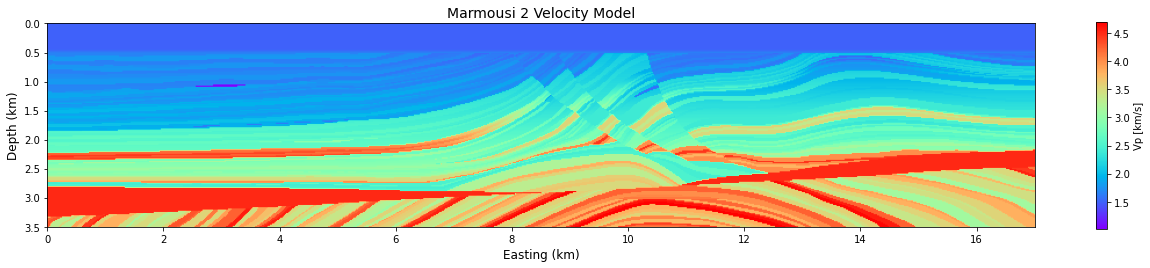

In [5]:
plt.figure(figsize=(18,4))
plt.imshow(mod.T, extent=(0, xmax/1e3, zmax/1e3, 0), cmap='rainbow')
plt.title("Marmousi 2 Velocity Model", fontsize=14)
plt.xlabel("Easting (km)", fontsize=12)
plt.ylabel("Depth (km)", fontsize=12)
plt.colorbar(shrink=0.8, label='Vp [km/s]')
plt.tight_layout()
plt.show()

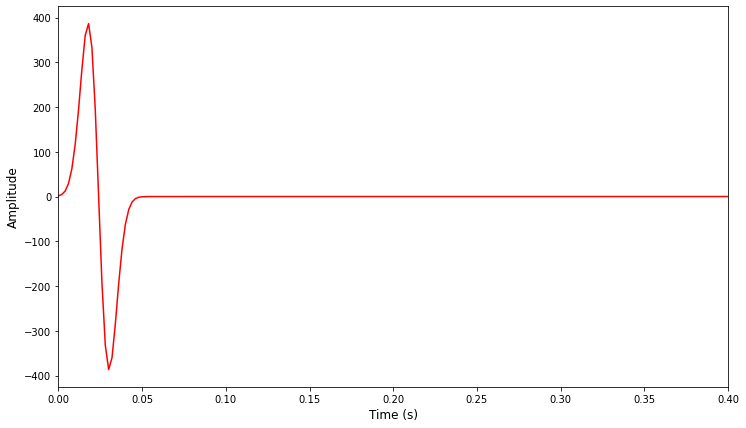

In [6]:
### Create source (Ricker wavelet)
# ltime, wave = ricker(f=f0)

# tvec = np.linspace(0, tmax, nt)

# src = np.zeros(nt)
# src[0] = -src_amp
# src[35] = src_amp
# src = np.convolve(src, wave, mode='same')
# clim = 0.1 * np.abs(src).max() #* dt**2 / (dx * dz)

### Create source (Gaussian wavelet)
period = 1/f0
xvec = np.linspace(-10, 10, nt)

wave = gauss_wavelet(x=xvec)
src = np.zeros(nt)

src[int(period/(2*dt))] = -src_amp/1000.0
src = np.convolve(src, wave, mode='same')

tvec = np.linspace(0, tmax, nt)
clim = 0.1 * np.abs(src).max()

plt.figure(figsize=(12, 7))
plt.plot(tvec, src, 'r')
# plt.plot(xvec, wave, 'r')
plt.xlim(0, 0.4)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Amplitude", fontsize=12)
plt.show()

<IPython.core.display.Javascript object>


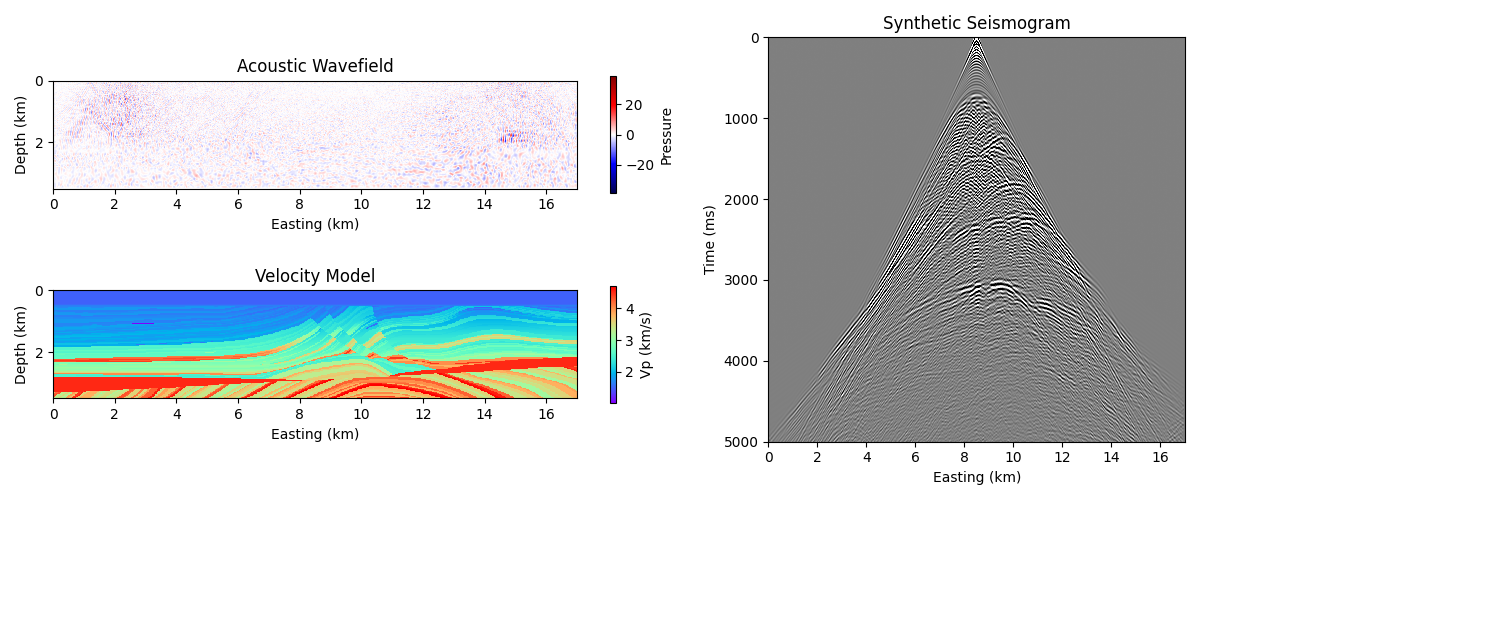

In [7]:
%matplotlib notebook
from pyevtk.hl import gridToVTK, pointsToVTK
from tqdm import tqdm

p = np.zeros((nx, nz))
pold = np.zeros((nx, nz))
pnew = np.zeros((nx, nz))
d2px = np.zeros((nx, nz))
d2pz = np.zeros((nx, nz))

seismogram = np.zeros((nx, nt))
jrec = jsrc

counter = 0

fig = plt.figure(figsize=(12, 5))

ax1 = plt.subplot2grid((2,10), (0, 0), colspan=6)
image = plt.imshow(p.T, cmap='seismic', animated=True, interpolation='spline36', 
                   extent=(0,xmax/1000,zmax/1000,0), vmin=-clim, vmax=clim, aspect='equal')
cbar = plt.colorbar(image, shrink=0.6)
cbar.set_label("Pressure")
ax1.set_title("Acoustic Wavefield")
ax1.set_xlabel("Easting (km)")
ax1.set_ylabel("Depth (km)")

ax2 = plt.subplot2grid((2,10), (1, 0), colspan=6)
mod = plt.imshow(vp.T/1000, cmap='rainbow', 
                 extent=(0,xmax/1000,zmax/1000,0), interpolation='nearest', aspect='equal')
cbar2 = plt.colorbar(mod, shrink=0.6)
cbar2.set_label("Vp (km/s)")
ax2.set_title("Velocity Model")
ax2.set_xlabel("Easting (km)")
ax2.set_ylabel("Depth (km)")

ax3 = plt.subplot2grid((2,10), (0, 6), rowspan=2, colspan=4)
seisimg = plt.imshow(seismogram.T, cmap='gray', animated=True, interpolation='spline36', 
                     extent=(0,xmax/1000,tmax*1e3,0), vmin=-0.3*clim, vmax=0.3*clim, aspect='auto')
# cbar = plt.colorbar(seisimg, shrink=0.8)
# cbar.set_label("Amplitude")
ax3.set_title("Synthetic Seismogram")
ax3.set_xlabel("Easting (km)")
ax3.set_ylabel("Time (ms)")

plt.ion()
plt.tight_layout()
plt.show(block=False)

for it in range(nt):
    # Update spatial derivative
    d2px, d2pz = update_d2p(p, nx, nz, dx, dz, d2px, d2pz)
    
    pnew = 2 * p - pold + vp2 * dt**2 * (d2px + d2pz)
    
    pnew *= Qmod   # rock Q parameter
    
    # Inject source
    pnew[isrc, jsrc] += src[it] #* dt**2 / (dx * dz)
    
    # Reflect boundary
    # pnew = reflection(pnew)
    
    # Absorb boundary
    pnew = absorb(p, pnew, vp, nx, nz, dt, dx)
    
    # Move forward
    pold, p = p, pnew
    
    # Update seismogram
    seismogram[:, it] = p[:, jrec]
    
    # To VTK
    # Yi = np.zeros(Xi.size)
    
    save_name = 'iteration'
    
    # Plot
    if it % isnap == 0:
        image.set_data(p.T)
        seisimg.set_data(seismogram.T)
        fig.canvas.draw()
        
        name_snap = f"image_out/acoustic_FD2D_{counter}.tiff"
        plt.savefig(name_snap, format='tiff', bbox_inches='tight', dpi=125)
        counter += 1